Some comments

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [49]:
import os
import copy
import numpy as np
repo_dir = '/datasets/hsc/repo/rerun/RC/w_2019_30/DM-20525'
assert os.path.isdir(repo_dir)

import lsst.daf.persistence as daf_persistence
butler = daf_persistence.Butler(repo_dir)

import lsst.verify as lsst_verify
import astropy.units as astropy_units

In [98]:
verify_dir = 'verify_photometry'
metric_set = lsst_verify.MetricSet.load_metrics_package(verify_dir)
spec_set = lsst_verify.SpecificationSet.load_metrics_package(verify_dir)

In [99]:
print(len(metric_set))
print(len(spec_set))

3
3


In [4]:
coadd_skymap = butler.get('deepCoadd_skyMap')

In [5]:
# Some plotting utilities for myself

def make_2d_histogram(xx, yy, dx, dy):
    """
    returns indices and counts of unique points on the map
    """
    i_color1 = np.round(xx/dx).astype(int)
    i_color2 = np.round(yy/dy).astype(int)
    dex_reverse = np.array([i_color1, i_color2])
    dex_arr = dex_reverse.transpose()
    # see http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array
    dex_raw = np.ascontiguousarray(dex_arr).view(np.dtype((np.void, dex_arr.dtype.itemsize*dex_arr.shape[1])))
    _, unique_rows, unique_counts = np.unique(dex_raw, return_index=True, return_counts=True)

    return unique_rows, unique_counts


def plot_color(xx, yy, dx, dy):
    dexes, cts = make_2d_histogram(xx, yy, dx, dy)
    sorted_dex = np.argsort(cts)
    dexes = dexes[sorted_dex]
    cts = cts[sorted_dex]
    plt.scatter(xx[dexes], yy[dexes], c=cts, s=5,
                cmap=plt.cm.gist_ncar, edgecolor='')

    plt.colorbar()


def plot_color_mesh(xx, yy, dx, dy, vmin=None, vmax=None):
    i_x_arr = np.round((xx-xx.min())/dx).astype(int)
    i_y_arr = np.round((yy-yy.min())/dy).astype(int)
    new_x = i_x_arr*dx
    new_y = i_y_arr*dy
    dex_list, ct_list = make_2d_histogram(new_x, new_y, dx, dy)

    if i_x_arr.min()<0 or i_y_arr.min()<0:
        raise RuntimeError('negative dex %e %d %e %d' %
                           (xx.min(), i_x_arr.min(), yy.min(), i_y_arr.min()))

    x_mesh=np.arange(xx.min(),xx.max()+0.1,dx)
    y_mesh=np.arange(yy.min(),yy.max()+0.1,dy)
    x_mesh,y_mesh = np.meshgrid(x_mesh,y_mesh,indexing='xy')
    z_mesh = np.zeros(shape=x_mesh.shape, dtype=int)
    ct_1000b = 0

    for dex, ct in zip(dex_list, ct_list):
        ix = i_x_arr[dex]
        iy = i_y_arr[dex]
        z_mesh[iy][ix] += ct

    z_mesh = np.ma.masked_where(z_mesh==0,z_mesh)
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, vmin=vmin, vmax=vmax)
                   #norm=matplotlib.colors.LogNorm(vmin=1.0,
                   #                               vmax=1.2e6))
    plt.colorbar(label='sources per pixel')

    ct_1000 = 0
    big_min = np.round((2.8-xx.min())/dx).astype(int)
    big_max = x_mesh.shape[0]

In [ ]:
#dir(coadd_skymap)

In [ ]:
#help(coadd_skymap.findTractPatchList)

In [6]:
import h5py

# this file contains the minimum and maximum RA, Dec values for each
# visit that actually exists in the HSC UDEEP rerun
spatial_lookup_filename = '/project/danielsf/valid_hsc_visit_extent_DM_20525.h5'
assert os.path.isfile(spatial_lookup_filename)
spatial_lookup = h5py.File(spatial_lookup_filename, 'r')

Find a (somewhat arbitrary) region on the sky

In [7]:
visit_num = spatial_lookup['visit'][11625]

In [8]:
all_visit = np.where(spatial_lookup['visit'][()]==visit_num)

In [9]:
print(len(all_visit[0]))

103


In [10]:
ra_min = spatial_lookup['ra_min'][()][all_visit].min()
ra_max = spatial_lookup['ra_max'][()][all_visit].max()
dec_min = spatial_lookup['dec_min'][()][all_visit].min()
dec_max = spatial_lookup['dec_max'][()][all_visit].max()

In [ ]:
all_coverage = np.where(np.logical_and(spatial_lookup['ra_center'][()]>ra_min,
                        np.logical_and(spatial_lookup['ra_center'][()]<ra_max,
                        np.logical_and(spatial_lookup['dec_center'][()]>dec_min,
                                       spatial_lookup['dec_center'][()]<dec_max))))

Find all the (tract, patch) pairs in that region

In [11]:
import lsst.geom as lsst_geom

In [12]:
pt_list = []
for ra in np.arange(ra_min, ra_max, 0.005):
    for dec in np.arange(dec_min, dec_max, 0.005):
        pt_list.append(lsst_geom.SpherePoint(ra, dec, lsst_geom.radians))

In [13]:
tract_patch_list = coadd_skymap.findTractPatchList(pt_list)

Define a method to select stars

In [14]:
def select_stars(dataset, calib, has_cmodel=True):
    """
    Select all sources with
    base_ClassificationExtendedness_value == 0
    & base_PsfFlux_flag == 0
    & np.abs(PsfMag-CModelMag)<0.03
    & PsfMag<25.0
    
    Parameters
    ----------
    dataset -- a src or deepCoadd_forcedSrc catalog
    calib -- the photometric calibration object needed to convert fluxes into mags
    
    Returns
    -------
    numpy array of PSF magnitudes
    numpy array of cModel magnitudes
    numpy array of booleans set to 'True' for everything that meets the criteria above
    """
    extendedness_flag = dataset['base_ClassificationExtendedness_value']==0
    well_measured_flag = dataset['base_PsfFlux_flag']==0
    mag_and_error = calib.instFluxToMagnitude(dataset, 'base_PsfFlux')
    mag = mag_and_error[:,0]
    mag_error = mag_and_error[:,1]
    colnames = dataset.getSchema().getNames()
    if 'modelfit_CModel_instFlux' in colnames:
        model_mag = calib.instFluxToMagnitude(dataset, 'modelfit_CModel')[:,0]
        mag_m_model_flag = np.abs(mag-model_mag)<0.03
    elif not has_cmodel:
        model_mag = np.NaN*np.ones(len(mag), dtype=float)
        mag_m_model_flag = np.ones(len(mag), dtype=bool)
    else:
        raise RuntimeError("Does not contain cModel")
    brightness_flag = mag<25.0
    brightness_finite = np.isfinite(mag)
    flag = extendedness_flag & well_measured_flag & mag_m_model_flag & brightness_finite & brightness_flag
    return mag, mag_error, model_mag, flag

Get all the clear stars from the deepCoadd_forcedSrc catalog.  Plot the stellar locus.

In [15]:
%%time
coadd_unq_id = []
coadd_g_mags = []
coadd_r_mags = []
coadd_i_mags = []

coadd_g_model = []
coadd_r_model = []
coadd_i_model = []

coadd_ra = []
coadd_dec = []

coadd_full_ra = []
coadd_full_dec = []
coadd_full_stars = []

ct_full_src = 0

for tract_sublist in tract_patch_list:
    tract_id = tract_sublist[0].getId()
    for patch_obj in tract_sublist[1]:
        patch_id = str(patch_obj.getIndex()).replace('(','').replace(')','').replace(' ','')
        blank_data_id = {'tract': tract_id, 'patch':patch_id}

        data_id_g = copy.deepcopy(blank_data_id)
        data_id_g['filter'] = 'HSC-G'
        data_id_r = copy.deepcopy(blank_data_id)
        data_id_r['filter'] = 'HSC-R'
        data_id_i = copy.deepcopy(blank_data_id)
        data_id_i['filter'] = 'HSC-I'

        if not butler.datasetExists('deepCoadd_forced_src', dataId=data_id_g):
            continue

        if not butler.datasetExists('deepCoadd_forced_src', dataId=data_id_r):
            continue

        if not butler.datasetExists('deepCoadd_forced_src', dataId=data_id_i):
            continue
        #print('loading %s' % str(blank_data_id))
        
        data_g = butler.get('deepCoadd_forced_src', dataId=data_id_g)#.asAstropy()
        data_r = butler.get('deepCoadd_forced_src', dataId=data_id_r)#.asAstropy()
        data_i = butler.get('deepCoadd_forced_src', dataId=data_id_i)#.asAstropy()

        np.testing.assert_array_equal(data_g['id'], data_r['id'])
        np.testing.assert_array_equal(data_g['id'], data_i['id'])
        np.testing.assert_array_equal(data_g['coord_ra'], data_r['coord_ra'])
        np.testing.assert_array_equal(data_g['coord_ra'], data_i['coord_ra'])
        np.testing.assert_array_equal(data_g['coord_dec'], data_r['coord_dec'])
        np.testing.assert_array_equal(data_g['coord_dec'], data_r['coord_dec'])

        calib_g = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_g)
        calib_r = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_r)
        calib_i = butler.get('deepCoadd_calexp_photoCalib', dataId=data_id_i)
    
        g_mag, g_mag_error, g_model, star_g = select_stars(data_g, calib_g)
        r_mag, r_mag_error, r_model, star_r = select_stars(data_r, calib_r)
        i_mag, i_mag_error, i_model, star_i = select_stars(data_i, calib_i)
        stars = star_g & star_r & star_i

        coadd_g_mags.append(g_mag[stars])
        coadd_g_model.append(g_model[stars])
        coadd_r_mags.append(r_mag[stars])
        coadd_r_model.append(r_model[stars])
        coadd_i_mags.append(i_mag[stars])
        coadd_i_model.append(i_model[stars])
    
        coadd_ra.append(data_g['coord_ra'][stars])
        coadd_dec.append(data_g['coord_dec'][stars])
        coadd_unq_id.append(data_g['id'][stars])
        coadd_full_ra.append(data_g['coord_ra'])
        coadd_full_dec.append(data_g['coord_dec'])
        coadd_full_stars.append(stars)

        ct_full_src += len(data_g['coord_ra'])    

        #coadd_g_mags.append(calib_g.instFluxToMagnitude(data_g['base_PsfFlux_instFlux']))
        #coadd_r_mags.append(calib_r.instFluxToMagnitude(data_r['base_PsfFlux_instFlux']))
        #coadd_i_mags.append(calib_i.instFluxToMagnitude(data_i['base_PsfFlux_instFlux']))

    
coadd_unq_id = np.concatenate(coadd_unq_id)
coadd_ra = np.concatenate(coadd_ra)
coadd_dec = np.concatenate(coadd_dec)
coadd_g_mags = np.concatenate(coadd_g_mags)
coadd_r_mags = np.concatenate(coadd_r_mags)
coadd_i_mags = np.concatenate(coadd_i_mags)
coadd_g_model = np.concatenate(coadd_g_model)
coadd_r_model = np.concatenate(coadd_r_model)
coadd_i_model = np.concatenate(coadd_i_model)

coadd_full_ra = np.concatenate(coadd_full_ra)
coadd_full_dec = np.concatenate(coadd_full_dec)
coadd_full_stars = np.concatenate(coadd_full_stars)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less


CPU times: user 1min 7s, sys: 13.4 s, total: 1min 21s
Wall time: 2min 18s


In [16]:
print(len(coadd_g_mags))
print(len(coadd_full_ra))
print(ct_full_src)
#print(data_g.getSchema())

16618
1691322
1691322


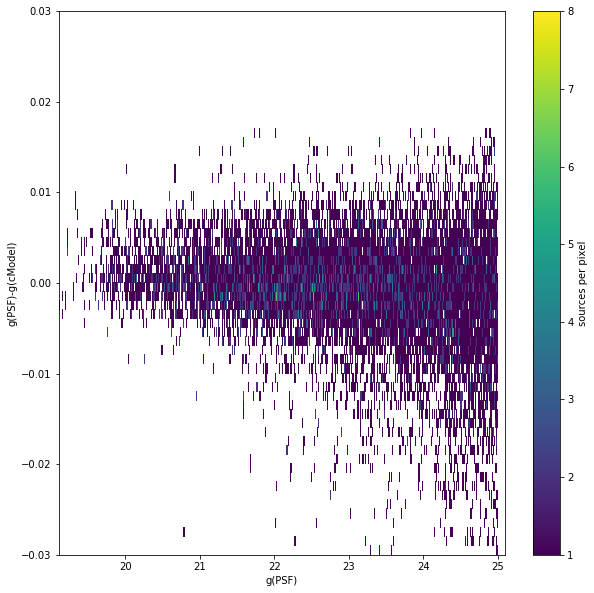

19.104963529549053


In [17]:
plt.figure(figsize=(10,10))
#plt.scatter(coadd_g_mags, coadd_g_mags-coadd_g_model)
plot_color_mesh(coadd_g_mags, coadd_g_mags-coadd_g_model, 0.002, 0.001)
plt.xlabel('g(PSF)')
plt.ylabel('g(PSF)-g(cModel)')
plt.ylim(-0.03,0.03)
plt.show()
print(coadd_g_mags.min())

16618


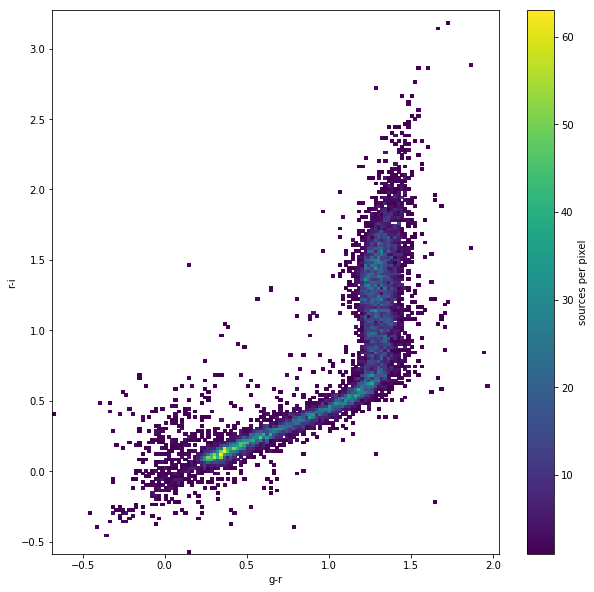

In [18]:
plt.figure(figsize=(10,10))
#plt.scatter(coadd_g_mags-coadd_r_mags, coadd_r_mags-coadd_i_mags,s=0.5)
valid_meas = np.logical_and(np.isfinite(coadd_g_mags),
                 np.logical_and(np.isfinite(coadd_r_mags), np.isfinite(coadd_i_mags)))

bright_enough = np.logical_and(coadd_g_mags<25.0,
                np.logical_and(coadd_r_mags<25.0, coadd_i_mags<25.0))

valid = np.where(np.logical_and(valid_meas, bright_enough))
print(len(valid[0]))
#plt.scatter(coadd_g_mags-coadd_r_mags,
#            coadd_r_mags-coadd_i_mags,s=0.5)

plot_color_mesh(coadd_g_mags-coadd_r_mags,
                coadd_r_mags-coadd_i_mags,
               0.02, 0.02)

#plt.hist2d(coadd_g_mags[valid]-coadd_r_mags[valid],
#           coadd_r_mags[valid]-coadd_i_mags[valid], bins=(200,200), cmap=plt.cm.jet)
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.ylim(20,35)
#plt.xlim(-5,5)
plt.show()

Build a KDTree of these sources for association with single image sources later on

In [19]:
import scipy.spatial as scipy_spatial
cdec = np.cos(coadd_full_dec)
coadd_spatial_data = np.array([cdec*np.cos(coadd_full_ra),
                               cdec*np.sin(coadd_full_ra),
                               np.sin(coadd_full_dec)]).transpose()
coadd_spatial_tree = scipy_spatial.cKDTree(coadd_spatial_data, leafsize=16)

NameError: name 'all_coverage' is not defined

Find all the single calexp visits in G, R, I that overlap the coadd region

In [21]:
ct_visits = 0
s_ra_min = spatial_lookup['ra_min'][()]
s_ra_max= spatial_lookup['ra_max'][()]
s_dec_min = spatial_lookup['dec_min'][()]
s_dec_max = spatial_lookup['dec_max'][()]
s_filter = spatial_lookup['filter'][()]
s_visit = spatial_lookup['visit'][()]
s_ccd = spatial_lookup['ccd'][()]
fset = set([b'HSC-G', b'HSC-R', b'HSC-I', b'HSC-Z', b'HSC-Y'])
desired_data_id_list = []
for rmin, rmax, dmin, dmax, fname, vv, ccd in \
zip(s_ra_min, s_ra_max, s_dec_min, s_dec_max, s_filter, s_visit, s_ccd):
    if fname not in fset:
        continue
    valid = (coadd_ra>=rmin) & (coadd_ra<=rmax) & (coadd_dec>=dmin) & (coadd_dec<=dmax)
    if np.sum(valid)>0:
        ct_visits += 1
        data_id = {'filter': fname.decode(), 'ccd': int(ccd), 'visit': int(vv)}
        desired_data_id_list.append(data_id)
print(ct_visits)
print(len(desired_data_id_list))
print(len(s_ra_min))

14356
14356
44496


In [22]:
# define a method so that we can load the calexp data in parallel with multiprocessing

import time
def load_data_id(data_id_list, output_dict, my_lock, repo_dir):

    t_start = time.time()
    assert os.path.isdir(repo_dir)

    local_butler = daf_persistence.Butler(repo_dir)
    print('PID %d considering %d data_ids (butler loaded in %e seconds)' %
          (os.getpid(),len(data_id_list),time.time()-t_start))
    t_start = time.time()
    ct_good = 0
    ct_bad = 0
    n_visits = len(data_id_list)
    local_ra = []
    local_dec = []
    local_mag = []
    local_mag_error = []
    local_filter=  []

    for data_id_single in data_id_list:
        data_single = local_butler.get('src', dataId=data_id_single, immediate=True)
        tract_id_list = []
        for ra, dec in zip(data_single['coord_ra'], data_single['coord_dec']):
            pt = lsst_geom.SpherePoint(ra, dec, lsst_geom.radians)
            tract_id_list.append(coadd_skymap.findTract(pt).getId())
        tract_id_list = np.array(tract_id_list)
        unq_tract_id_list = np.unique(tract_id_list)
        for tract_id in unq_tract_id_list:
            is_tract = (tract_id_list==tract_id)
            
            data_id_single['tract'] = int(tract_id)
            try:
                calib_single = local_butler.get('jointcal_photoCalib',
                                                dataId=data_id_single)
            except:
                continue
            wcs = local_butler.get('jointcal_wcs', dataId=data_id_single)

            active_data = data_single[is_tract]
            for record in active_data:
                record.updateCoord(wcs)

            psf_mag, psf_mag_error, model_mag, star_dex = select_stars(active_data,
                                                                       calib_single,
                                                                       has_cmodel=False)
        
            local_ra.append(active_data['coord_ra'][star_dex])
            local_dec.append(active_data['coord_dec'][star_dex])
            local_mag.append(psf_mag[star_dex])
            local_mag_error.append(psf_mag_error[star_dex])
            local_filter.append([data_id_single['filter']]*np.sum(star_dex))
            assert len(local_filter[-1]) == len(local_ra[-1])
        
        ct_good += 1
    duration = (time.time()-t_start)/3600.0
    print('good: %d bad: %d in %.2e hrs' % (ct_good, ct_bad, duration))

    if len(local_ra)>0:
        with my_lock:
            output_dict['ra'] += local_ra
            output_dict['dec'] += local_dec
            output_dict['filter'] += local_filter
            output_dict['mag'] += local_mag
            output_dict['mag_error'] += local_mag_error
    #print('%d is done good: %d bad: %d' % (os.getpid(),ct_good,ct_bad))


Get the RA, Dec, magnitue, and filter of all of the single image stars in HSC UDEEP

(This will take about five minutes to run)

In [23]:
%%time
import multiprocessing

mgr = multiprocessing.Manager()
my_lock = mgr.Lock()
output_dict = mgr.dict()
butler_dict = mgr.dict()
for k in ['ra', 'dec', 'mag', 'mag_error', 'filter']:
    output_dict[k] = mgr.list()

t_start = time.time()
single_ra = []
single_dec = []
single_mag = []
single_mag_error= []
single_model_mag = []
single_filter = []
ct_single = 0
n_visits = len(desired_data_id_list)

n_fourth = n_visits//4
print(n_visits, n_fourth)
p_list = []

#test_data_id_list = desired_data_id_list[:800]
#n_visits = len(test_data_id_list)


#load_data_id(desired_data_id_list[:10], output_dict, my_lock, repo_dir)


d_data_id=500
for i_start in range(0,n_visits,d_data_id):
    p = multiprocessing.Process(target=load_data_id,
                                args=[desired_data_id_list[i_start:i_start+d_data_id],
                                      output_dict, my_lock, repo_dir])

    p.start()
    p_list.append(p)
    while len(p_list)>=4:
        exit_code_list = []
        for p in p_list:
            exit_code_list.append(p.exitcode)
        for i_p in range(len(exit_code_list)-1, -1, -1):
            if exit_code_list[i_p] is not None:
                p_list.pop(i_p)

for p in p_list:
    p.join()

single_ra = np.concatenate(output_dict['ra'])
single_dec = np.concatenate(output_dict['dec'])
single_mag = np.concatenate(output_dict['mag'])
single_mag_error = np.concatenate(output_dict['mag_error'])
single_filter = np.concatenate(output_dict['filter'])


print('all done')




14356 3589
PID 852 considering 500 data_ids (butler loaded in 3.397567e+00 seconds)
PID 848 considering 500 data_ids (butler loaded in 3.519511e+00 seconds)
PID 840 considering 500 data_ids (butler loaded in 3.555536e+00 seconds)
PID 844 considering 500 data_ids (butler loaded in 3.636430e+00 seconds)
good: 500 bad: 0 in 2.18e-02 hrs
good: 500 bad: 0 in 2.19e-02 hrs
good: 500 bad: 0 in 2.23e-02 hrs
PID 880 considering 500 data_ids (butler loaded in 3.097776e+00 seconds)
PID 900 considering 500 data_ids (butler loaded in 3.100899e+00 seconds)
PID 920 considering 500 data_ids (butler loaded in 3.039506e+00 seconds)
good: 500 bad: 0 in 2.57e-02 hrs
PID 946 considering 500 data_ids (butler loaded in 2.842572e+00 seconds)
good: 500 bad: 0 in 3.22e-02 hrs
PID 969 considering 500 data_ids (butler loaded in 3.107902e+00 seconds)
good: 500 bad: 0 in 3.67e-02 hrs
PID 991 considering 500 data_ids (butler loaded in 3.036023e+00 seconds)
good: 500 bad: 0 in 5.29e-02 hrs
PID 1013 considering 500 dat

In [24]:
print(len(single_ra))

3612857


Associate single image sources with coadd forced sources

First associate single detections with all coadd sources (not just stars) and only select those whose nearest neighbor is a star

In [25]:
cdec = np.cos(single_dec)
single_spatial_data = np.array([cdec*np.cos(single_ra),
                                cdec*np.sin(single_ra),
                                np.sin(single_dec)]).transpose()

In [26]:
raw_fit_dist, raw_fit_dex = coadd_spatial_tree.query(single_spatial_data, k=2)

In [27]:
# select only sources whose nearest neighbor has been identified as a star in the coadd,
# who are within 0.05 arcsec of their nearest neighbor
# and are 10 times closer to their nearest neighbor than to their second nearest neighbor
# and are at least 2 arcsec away from their second nearest neighbor

raw_fit_d_trans = raw_fit_dist.transpose()
raw_fit_d_ratio = raw_fit_d_trans[0]/raw_fit_d_trans[1]
raw_fit_d_arcsec= raw_fit_d_trans[0]/np.radians(1/3600)
raw_fit_d2_arcsec = raw_fit_d_trans[1]/np.radians(1/3600)
raw_fit_is_star = coadd_full_stars[raw_fit_dex.transpose()[0]]

assoc_to_stars = np.where(np.logical_and(raw_fit_d_ratio<0.1,
                          np.logical_and(raw_fit_d_arcsec<0.05,
                          np.logical_and(raw_fit_d2_arcsec>2.0,
                                         raw_fit_is_star))))

In [28]:
print(len(assoc_to_stars[0]))

253176


Select down to only those single exposure sources that were associated with stars

In [29]:
single_ra_stellar = single_ra[assoc_to_stars]
single_dec_stellar = single_dec[assoc_to_stars]
single_mag_stellar = single_mag[assoc_to_stars]
single_mag_error_stellar = single_mag_error[assoc_to_stars]
single_filter_stellar = single_filter[assoc_to_stars]

Re-do the nearest neighbor fit, only checking against coadd stars

In [30]:
cdec = np.cos(single_dec_stellar)
single_spatial_data = np.array([cdec*np.cos(single_ra_stellar),
                                cdec*np.sin(single_ra_stellar),
                                np.sin(single_dec_stellar)]).transpose()

In [31]:
%%time
cdec = np.cos(coadd_dec)
coadd_stellar_spatial = np.array([np.cos(coadd_ra)*cdec,
                                  np.sin(coadd_ra)*cdec,
                                  np.sin(coadd_dec)]).transpose()
coadd_spatial_tree_stellar = scipy_spatial.cKDTree(coadd_stellar_spatial, leafsize=16)
fit_dist, fit_dex = coadd_spatial_tree_stellar.query(single_spatial_data, k=2)

CPU times: user 251 ms, sys: 6.19 ms, total: 257 ms
Wall time: 257 ms


In [32]:
# Select only those stars that are within 0.05 arcseconds of a coadd force source
# and for whom the nearest neighbor is 10 times closer than the next nearest neighbor

fit_d_trans = fit_dist.transpose()
fit_d_ratio = fit_d_trans[0]/fit_d_trans[1]
fit_d_arcsec= fit_d_trans[0]/np.radians(1/3600)
fit_d2_arcsec = fit_d_trans[1]/np.radians(1/3600)
print(fit_d2_arcsec.min())

valid = np.where(np.logical_and(fit_d_ratio<0.1,
                 np.logical_and(fit_d2_arcsec>2.0,
                                fit_d_arcsec<0.05,)))
np.testing.assert_array_equal(valid[0], np.arange(0,len(single_ra_stellar), dtype=int))

single_ra_stellar = single_ra_stellar[valid]
single_dec_stellar = single_dec_stellar[valid]
single_mag_stellar = single_mag_stellar[valid]
single_mag_error_stellar = single_mag_stellar[valid]
single_filter_stellar = single_filter_stellar[valid]
single_fit_dex = fit_dex[:,0][valid]

2.000502086986367


In [33]:
# double check that sources are correctly associated

d_max = -1.0
for sra, sdec, dex in zip(single_ra_stellar, single_dec_stellar, single_fit_dex):
    cdec = np.cos(sdec)
    xyz_s = np.array([cdec*np.cos(sra), cdec*np.sin(sra), np.sin(sdec)])
    
    cdec = np.cos(coadd_dec[dex])
    cra = coadd_ra[dex]
    xyz_c = np.array([cdec*np.cos(cra), cdec*np.sin(cra), np.sin(coadd_dec[dex])])
    dot_prod = np.dot(xyz_s, xyz_c)
    dd = np.arccos(dot_prod)/np.radians(1.0/3600.0)
    if dd>d_max:
        d_max = dd
        print('d_max %.2e arcsec' % d_max)
    

d_max 2.48e-02 arcsec
d_max 2.70e-02 arcsec
d_max 3.57e-02 arcsec
d_max 3.90e-02 arcsec
d_max 4.05e-02 arcsec
d_max 4.19e-02 arcsec
d_max 4.69e-02 arcsec
d_max 4.99e-02 arcsec
d_max 5.00e-02 arcsec
d_max 5.01e-02 arcsec


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in arccos


In [34]:
coadd_mag_dict = {'HSC-G': coadd_g_mags,
                 'HSC-R': coadd_r_mags,
                 'HSC-I': coadd_i_mags}
bp_list = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']

In [35]:
print('HSC-I' in single_filter_stellar)

True


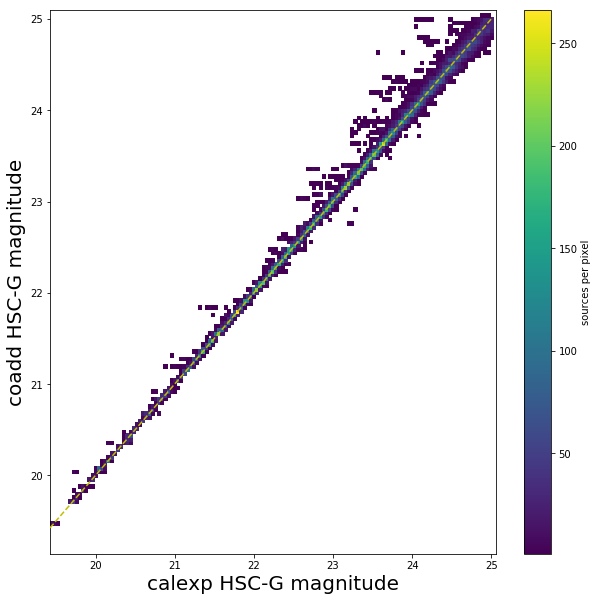

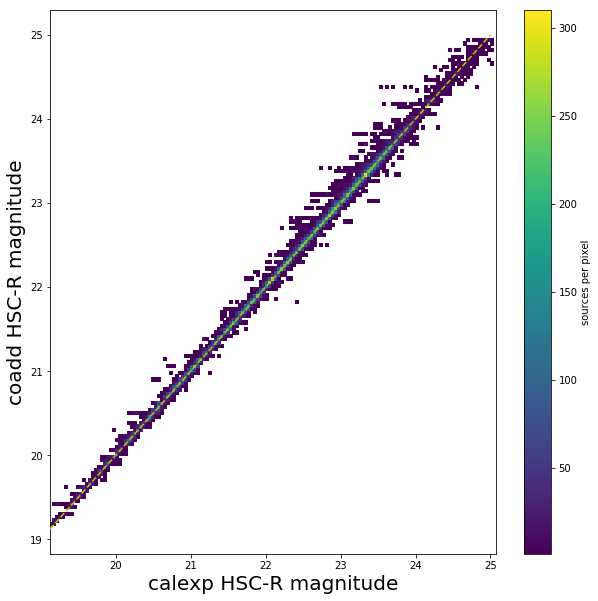

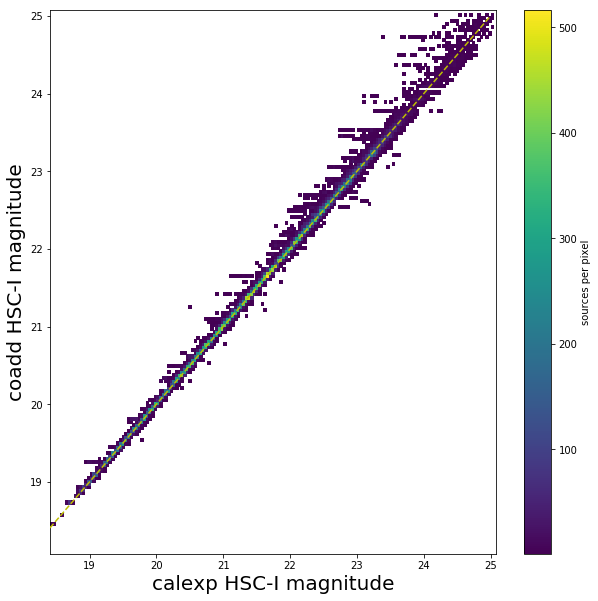

In [36]:
# compare single calexp magnitudes to coadd magnitudes

for bp in bp_list:
    if bp not in coadd_mag_dict:
        continue
    valid = np.where(np.char.find(single_filter_stellar, bp)==0)
    plt.figure(figsize=(10,10))
    s = single_mag_stellar[valid]
    plot_color_mesh(s,
                    coadd_mag_dict[bp][single_fit_dex[valid]],
                    0.04, 0.04)
    plt.plot([s.min(),s.max()], [s.min(),s.max()], linestyle='--',
             color='y', zorder=3)
    plt.xlabel('calexp %s magnitude' % bp, fontsize=20)
    plt.ylabel('coadd %s magnitude' % bp, fontsize=20)
    

In [37]:
pa1_limit = {}
pa1_limit['HSC-G'] = 0.005
pa1_limit['HSC-R'] = 0.005
pa1_limit['HSC-I'] = 0.005
pa1_limit['HSC-Z'] = 0.0075
pa1_limit['HSC-Y'] = 0.0075

pa2_limit = {}
pa2_limit['HSC-G'] = 0.015
pa2_limit['HSC-R'] = 0.015
pa2_limit['HSC-I'] = 0.015
pa2_limit['HSC-Z'] = 0.0225
pa2_limit['HSC-Y'] = 0.0225

pf1 = 0.1

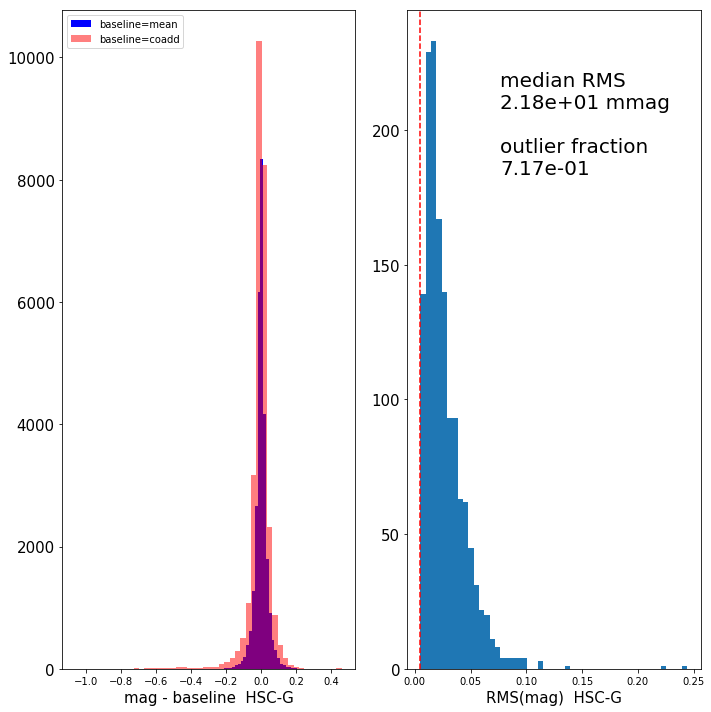

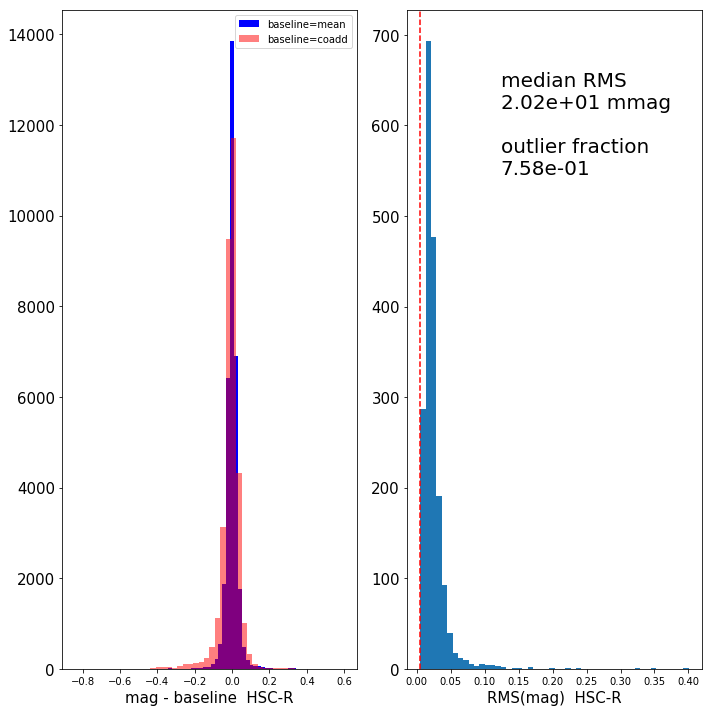

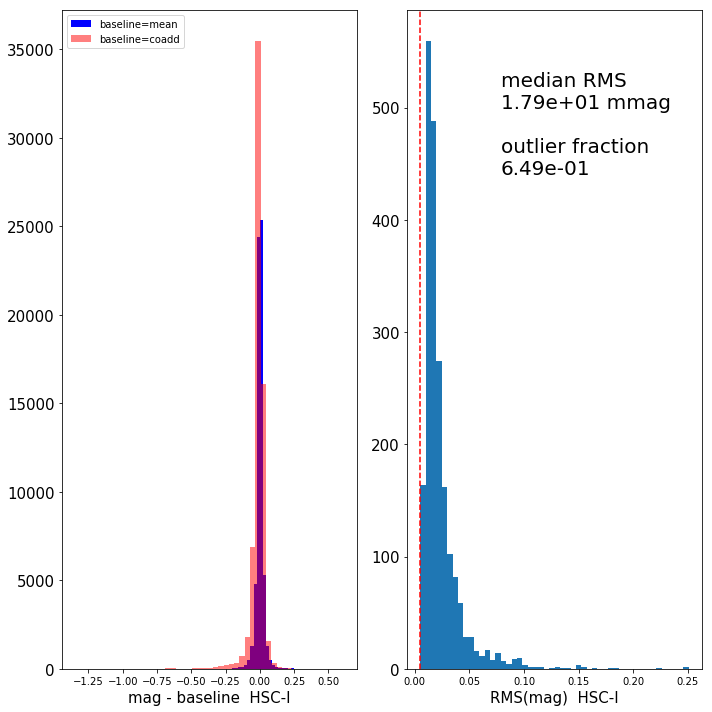

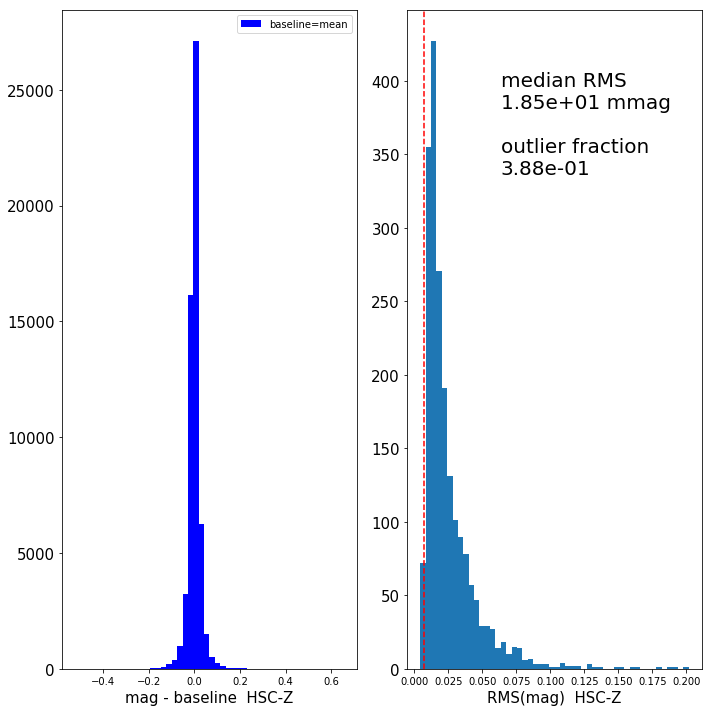

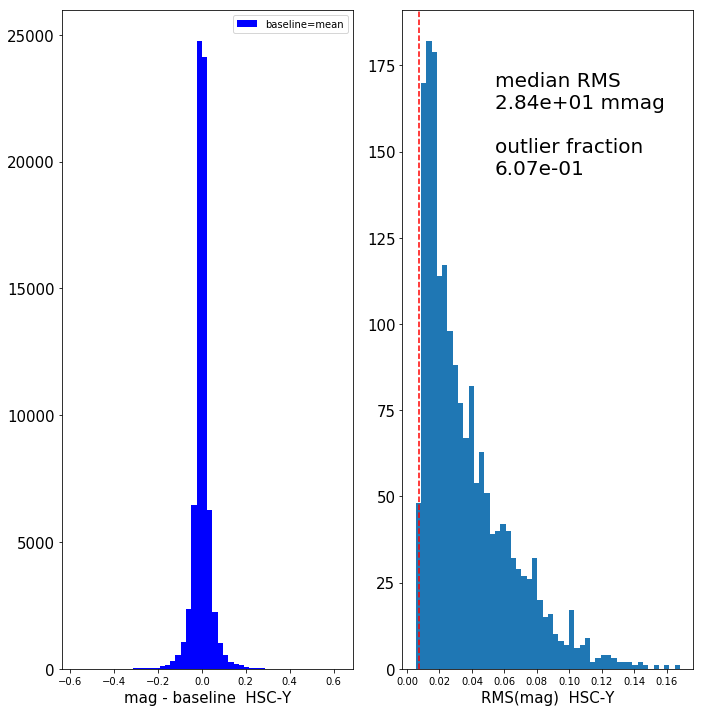

In [109]:
median_rms = {}
outlier_frac = {}

measurement_list = []

for bp in bp_list:
    mag_scatter = []
    mag_coadd_scatter = []
    mag_rms = []
    is_filter = np.where(np.char.find(single_filter_stellar, bp)==0)
    mag = single_mag_stellar[is_filter]
    dex = single_fit_dex[is_filter]
    unq_id_list = np.unique(single_fit_dex)
    for unq_id in unq_id_list:
        is_obj = np.where(dex==unq_id)
        mag_arr = mag[is_obj]
        mean_mag = np.mean(mag_arr)
        mag_scatter.append(mag_arr-mean_mag)
        if bp in coadd_mag_dict:
            mag_coadd_scatter.append(mag_arr-coadd_mag_dict[bp][unq_id])
        if len(mag_arr) > 10:
            mag_rms.append(np.std(mag_arr))
    mag_scatter = np.concatenate(mag_scatter)
    if bp in coadd_mag_dict:
        mag_coadd_scatter = np.concatenate(mag_coadd_scatter)
    mag_rms = np.array(mag_rms)
    assert len(mag)==len(mag_scatter)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.hist(mag_scatter, bins=50, label='baseline=mean', zorder=0, color='b')
    if bp in coadd_mag_dict:
        plt.hist(mag_coadd_scatter, bins=50, label='baseline=coadd', zorder=1, alpha=0.5, color='r')
    plt.xlabel('mag - baseline  %s' % bp, fontsize=15)
    plt.yticks(fontsize=15)
    #plt.xticks(fontsize=15)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.hist(mag_rms, bins=50)
    plt.axvline(pa1_limit[bp], linestyle='--', color='r')
    plt.xlabel('RMS(mag)  %s' % bp, fontsize=15)
    plt.yticks(fontsize=15)
    #plt.xticks(fontsize=15)
    
    median_rms[bp] = np.median(mag_rms)
    outliers = np.where(mag_rms>pa2_limit[bp])
    outlier_frac[bp] = len(outliers[0])/len(mag_rms)
    
    if bp in 'uzy':
        pa_tag = 'uzy'
    else:
        pa_tag = 'gri'
    meas_pa1 = lsst_verify.Measurement('photometric_repeatability.PA1%s' % pa_tag,
                                       np.median(mag_rms)*astropy_units.mag, notes={'bandpass': bp})
    meas_pf1 = lsst_verify.Measurement('photometric_repeatability.PF1',
                                       np.sum(mag_rms>pa2_limit[bp])/len(mag_rms),
                                       notes={'bandpass': bp})
    
    measurement_list.append(meas_pa1)
    measurement_list.append(meas_pf1)
    
    xcoord = mag_rms.min()+0.3*(mag_rms.max()-mag_rms.min())
    ycoord = plt.ylim()[0]+0.75*(plt.ylim()[1]-plt.ylim()[0])
    plt.text(xcoord,ycoord,'median RMS\n%.2e mmag\n\noutlier fraction\n%.2e' %
             (median_rms[bp]*1000.0, outlier_frac[bp]),fontsize=20)
    
    plt.tight_layout()

In [110]:
job = lsst_verify.Job(metrics=metric_set, specs=spec_set, measurements=measurement_list)
#for m in measurement_list:
#    job.measurements.insert(m)
#    print(len(job.measurements))


In [111]:
job.report().show()

Status,Specification,Measurement,Test,Metric Tags,Spec. Tags
❌,photometric_repeatability.PA1gri.design,0.0 $\mathrm{mag}$,$x$ <= 0.005 $\mathrm{mag}$,N/A,
❌,photometric_repeatability.PF1.design,0.6 $\mathrm{}$,$x$ <= 0.1 $\mathrm{}$,N/A,


In [107]:
len(spec_set)

3

In [108]:
len(job.measurements)

1

In [ ]:
test = butler.get('src', dataId=desired_data_id_list[0])

In [ ]:
valid = np.where(np.abs(mag_coadd_scatter)<0.05)
print(len(valid[0]))
print(mag_rms.min())
print(len(mag_coadd_scatter))

In [ ]:
butler.getKeys('jointcal_photoCalib')

In [ ]:
butler.getKeys('jointcal_wcs')

In [ ]:
for tt in tract_patch_list:
    print(tt[0])

In [ ]:
dir(coadd_skymap)

In [ ]:
coadd_skymap.findTract(pt_list[1]).getId()

In [ ]:
data_id = {'filter': 'HSC-I', 'ccd': 0, 'visit': 7274, 'tract': 8523}

In [ ]:
butler.datasetExists('jointcal_photoCalib', dataId=data_id)

In [ ]:
pc = butler.get('jointcal_photoCalib', dataId=data_id)

In [ ]:
dir(butler)

In [ ]:
butler.queryMetadata('jointcal_photoCalib', ['visit', 'ccd', 'filter', 'tract'], dataId=data_id)

In [ ]:
data_id

In [43]:
help(lsst_verify.Job.measurements.setter)

Help on built-in function setter:

setter(...) method of builtins.property instance
    Descriptor to change the setter on a property.

